# Problem Scenario

We need to train a model to recognise the emotion of the movie review as positive or negative. This is a binary classification problem. The dataset used here is known as 'Polarity Dataset'. This dataset has following properties:

* It only comprises of English reviews.
* The text is in lowercase.
* There is whitespace around punctuations like periods, commas, and brackets.
* Text has been split into one sentence per line.

This problem is approached in three stages:

&nbsp; &nbsp; **A. Data Preprocessing**

&nbsp; &nbsp; **B. Bag Of Words Representation**

&nbsp; &nbsp; **C. Sentiment Analysis Model**


# A. DATA PREPROCESSING

This stage involves the following steps:

* Separation of data into training and test set.
* Loading and cleaning the data.
* Defining a vocabulary of preferred words.

## A.1. Training and Testing set

The dataset contains 1000 positive and 1000 negative reviews. Among them, 900 positive and 900 negative reviews are used as training sets and the remaining 100 positive and 100 negative reviews are used as test data.

In [1]:
train_set_pos_path = "Data/Training Data/pos/"
train_set_neg_path = "Data/Training Data/neg/"

test_set_pos_path = "Data/Test Data/pos/"
test_set_neg_path = "Data/Test Data/neg/"


## A.2. Load the file

The **load_file** method helps to load the content of a file into memory.

In [2]:
def load_file(filepath):
    file = open(filepath, 'r')  # open the file in the read only mode
    text = file.read()          # read the contents of the file
    file.close()                # close the file 
    return text

## A.2. Clean the File

The **clean_file** method  helps to turn the contents of the file into clean tokens. The following methods are employed in this project to generate clean tokens.

* Split on white space.
* Remove all the punctuations.
* Remove all words that does not purely consist of alphabetic characters.
    (after this step, we are only left with alphabetic tokens)
* Remove all stop words.
* Remove all words with small length (length <= 1 character).

In [3]:
from nltk.corpus import stopwords
import string

def clean_file(file):
    tokens = file.split()                                 # split into tokens on whitespace
    
    table = str.maketrans('' , '', string.punctuation)    # remove punctuation
    tokens = [w.translate(table) for w in tokens]
    
    tokens = [word for word in tokens if word.isalpha()]  # remove non-alphabetic tokens
    
    set_of_stop_words = set(stopwords.words('english'))   # remove stop words
    tokens = [word for word in tokens if not word in set_of_stop_words]
    
    tokens = [word for word in tokens if len(word) > 1]   # remove tokens of length <= 1
    
    return tokens

In [4]:
# an example to understand the effects of load_file and clean_file methods

filename = 'Data/Training Data/pos/cv034_29647.txt'
text = load_file(filename)
tokens = clean_file(text)

print("\n************************************************PRE CLEANING(ORIGINAL TEXT)**********************************************\n")
print(text)
print("*************************************************POST CLEANING(TOKENS)***************************************************\n")
print(tokens)
print("*************************************************************************************************************************\n")


************************************************PRE CLEANING(ORIGINAL TEXT)**********************************************

plot : derek zoolander is a male model . 
he is also very dumb and impressionable . 
for that reason , he is secretly hired and trained ( so secret , that even he doesn't know about it ) by an underground fashion syndicate to assassinate the prime minister of malaysia , who wants to abolish child labor in his country . 
will zoolander fulfill the dirty deed ? 
will zoolander ever grace the world his new " look " ? 
is this a funny movie ? 
find out below . . . 
critique : there's a place in our world for " stupid comedies " . 
films which don't pretend to take themselves seriously , are based on idiotic premises and filled with dumb jokes . 
there's also a time for them and many would argue that this difficult period of our history , might be an ideal circumstance during which to " relax " by watching something so completely frivolous . 
well , if you're in the mo

## A.3. Define a Vocabulary

It is necessary to define a vocabulary of words to vectorise the document of reviews. The below method defines a vocabulary of words and maintains the count of the occurrence of each word in the vocabulary.

In [5]:
from os import listdir
from collections import Counter

def add_words_to_vocab_and_update_count(directory, vocab):
    for filename in listdir(directory):
        filepath = directory + '/' + filename
        text = load_file(filepath)  # load the file
        tokens = clean_file(text)   # clean the file
        vocab.update(tokens)        # update count of the word in the vocab
    
vocab = Counter()   # to hold tokens and their respective counts. Eg: [('tok1',tok1_count), ('tok2',tok2_count),...]

add_words_to_vocab_and_update_count('Data/Training Data/pos', vocab)
add_words_to_vocab_and_update_count('Data/Training Data/neg', vocab)

print('The length of the vocab: ',len(vocab))
print('\nTop 10 frequently occuring words:',vocab.most_common(10))

The length of the vocab:  44276

Top 10 frequently occuring words: [('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844)]


**Intuitively** we can say that most infrequently occuring words may not contribute much to the training of model. So only those words occuring more than two times are considered in the token list. 

Note: It is not a hard rule to use the threshold of two. 

In [6]:
min_occurrence = 2

print('Total Tokens (Before): ',len(vocab))
tokens = [token for token,count in vocab.items() if count >= min_occurrence]    # list of tokens with count >= 2
print('Total Tokens (After) : ',len(tokens))


Total Tokens (Before):  44276
Total Tokens (After) :  25767


In [7]:
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_list(tokens, 'vocab.txt')   # the vocabulary is saved in a text file for later use

# B. BAG OF WORDS REPRESENTATION

This stage focuses on preparing the data for the training model. It involves following steps:

* Converting reviews to lines of tokens.
* Encoding reviews with a bag-of-words model representation.

## B.1. Reviews to lines of tokens (Reviews -> Tokens)

Here, each review file is loaded to memory and cleaned for tokens. The obtained tokens are further cleaned by retaining only those tokens that are also in vocabulary we defined previously. The resultant tokens are joined by whitespace. 
**reviews_to_lines** method returns the list of reviews in a specified location. For example, let's say we have 100 reviews in a folder. Then the **reviews_to_lines** method returns a list of length 100. Each index of the list stores a single review(cleaned review) with the words/tokens separated by whitespace.

In [8]:
def reviews_to_lines(directory, vocab):
    lines = []
    for filename in listdir(directory):
        filepath = directory + filename
        text = load_file(filepath)  # load the file
        tokens = clean_file(text)   # clean the file
        tokens = [word for word in tokens if word in vocab]   # filter by vocab
        line = ' '.join(tokens)     # single review -> tokens -> filter -> single line with tokens spaced by whitespace
        lines.append(line)          # list of reviews. Single review is stored at each index of the list
    return lines

# load the vocabulary
vocab = load_file("vocab.txt")
vocab = vocab.split()
vocab = set(vocab)

# Training Data : reviews to lines
train_pos_reviews_to_lines = reviews_to_lines(train_set_pos_path, vocab)
train_neg_reviews_to_lines = reviews_to_lines(train_set_neg_path, vocab)

# Test Data : reviews to lines
test_pos_reviews_to_lines = reviews_to_lines(test_set_pos_path, vocab)
test_neg_reviews_to_lines = reviews_to_lines(test_set_neg_path, vocab)

# Total training and testing data
train_reviews = train_pos_reviews_to_lines + train_neg_reviews_to_lines
test_reviews  = test_pos_reviews_to_lines  + test_neg_reviews_to_lines

## B.2. Reviews to Bag-Of-Words Vectors (Reviews -> Tokens -> Vectors)

The data that is fed to the training model should be encoded into numerical values and all the training examples should be of uniform length. So far what we have is the training and test data in the texual form and of non-uniform length. We use the Bag-Of-Words model to encode the data in order to make it suitable for training/learning. In this model each document/review is transformed to an encoded vector where each word/token is assigned a score. The length of the vector corresponds to the length of the vocabulary. There are different methods for scoring the words like **freq, binary, count** and **tfidf**. In this project we use 'freq' for scoring the words. Let's understand how it works.

**Example:** vocab = {this, that, is, mine, not, cat, dog} and text = "This this is mine". 

The encoded text using the 'freq' scoring method = [0.5, 0.0, 0.25, 0.25, 0.0, 0.0, 0.0]

* the number of words/tokens in the text is 4.
* the length of the vector = length of the vocabulary = 7
* score of 'this' = (total occurence of 'this' in the text) / (total words in the text) = 2/4 = 0.5
* the score of 'this' is stored in the index corresponding to 'this' in the vector( for now, we can assume it to be in the same index as in vocabulary).
* the words 'that', 'not', 'cat', 'dog' do not occur in the text so their corresponding indexes in the vector is assigned a score of zero(because 0/4 = 0)

We use **Tokenizer** class provided by Keras to achieve this.

In [9]:
from keras.preprocessing.text import Tokenizer

def prepare_data(train_reviews, test_reviews, mode):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_reviews) # fit the tokenizer on the texts

    xtrain = tokenizer.texts_to_matrix(train_reviews, mode = mode)  # encode the training set
    xtest  = tokenizer.texts_to_matrix(test_reviews, mode = mode)   # encode the test set

    return xtrain, xtest

xtrain, xtest = prepare_data(train_reviews, test_reviews, mode = 'freq')

print(" Shape of xtrain: ", xtrain.shape)
print(" Shape of xtest : ", xtest.shape)

Using TensorFlow backend.


 Shape of xtrain:  (1800, 25768)
 Shape of xtest :  (200, 25768)


With the shape of the xtrain and xtest we can understand the following:

* each review is encoded in the vector of 25768 items/values.
* there are total of 1800 training examples and 200 test examples.

Now, we need the class labels for these reviews. 'Positive' is encoded as 0 and 'Negative' is encoded as 1. Thus, we create ytrain and ytest as shown below.

In [10]:
import numpy as np

train_pos_limit = int(xtrain.shape[0]/2) # upper limit of pos training reviews
train_neg_limit = xtrain.shape[0]        # upper limit of neg training reviews
test_pos_limit  = int(xtest.shape[0]/2)  # upper limit of pos test reviews
test_neg_limit  = xtest.shape[0]         # upper limit of neg test reviews 

ytrain = np.array([0 for i in range(0, train_pos_limit)] + [1 for i in range(train_pos_limit, train_neg_limit)])
ytest  = np.array([0 for i in range(0, test_pos_limit)]  + [1 for i in range(test_pos_limit, test_neg_limit)])


# C. Sentiment Analysis Model

In this project we develop a multi-layered perceptron to predict the sentiment/emotion of the reviews.

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def seniment_analysis_model(xtrain, ytrain):
    n_words = xtrain.shape[1]  
    # define the network
    model = Sequential()
    model.add(Dense(50, input_shape = (n_words, ), activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    # compile the network
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # fit the network to the training data
    history = model.fit(xtrain, ytrain, epochs = 25, verbose = 2)
    
    return model, history

classifier, model_history = seniment_analysis_model(xtrain, ytrain)

Epoch 1/25
 - 3s - loss: 0.6914 - acc: 0.5567
Epoch 2/25
 - 2s - loss: 0.6805 - acc: 0.8328
Epoch 3/25
 - 2s - loss: 0.6601 - acc: 0.9172
Epoch 4/25
 - 2s - loss: 0.6311 - acc: 0.8611
Epoch 5/25
 - 2s - loss: 0.5927 - acc: 0.9272
Epoch 6/25
 - 2s - loss: 0.5486 - acc: 0.9350
Epoch 7/25
 - 2s - loss: 0.5021 - acc: 0.9494
Epoch 8/25
 - 2s - loss: 0.4555 - acc: 0.9544
Epoch 9/25
 - 2s - loss: 0.4102 - acc: 0.9594
Epoch 10/25
 - 2s - loss: 0.3692 - acc: 0.9639
Epoch 11/25
 - 2s - loss: 0.3306 - acc: 0.9694
Epoch 12/25
 - 2s - loss: 0.2974 - acc: 0.9772
Epoch 13/25
 - 2s - loss: 0.2670 - acc: 0.9811
Epoch 14/25
 - 2s - loss: 0.2397 - acc: 0.9828
Epoch 15/25
 - 2s - loss: 0.2154 - acc: 0.9878
Epoch 16/25
 - 2s - loss: 0.1940 - acc: 0.9906
Epoch 17/25
 - 2s - loss: 0.1751 - acc: 0.9922
Epoch 18/25
 - 2s - loss: 0.1582 - acc: 0.9933
Epoch 19/25
 - 2s - loss: 0.1430 - acc: 0.9950
Epoch 20/25
 - 2s - loss: 0.1298 - acc: 0.9956
Epoch 21/25
 - 2s - loss: 0.1177 - acc: 0.9961
Epoch 22/25
 - 2s - lo

Now, we will evaluate the performance of the trained model on the test set.

In [12]:
loss, accuracy = classifier.evaluate(xtest, ytest, verbose = 0)
print('Test accuracy = ', (accuracy * 100))

Test accuracy =  90.5


Our model performs with an accurancy of around 90 percent on the test set.


# Additional Information



In [13]:
model_history.history.keys()

dict_keys(['loss', 'acc'])

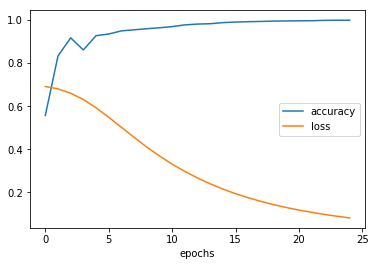

In [14]:
# plot for visulizing how the loss and accuracy changes with each epoch of training

import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(model_history.history['acc'], label = 'accuracy')
plt.plot( model_history.history['loss'], label = 'loss')
plt.xlabel('epochs')
plt.legend(loc = 'center right')